In [9]:
import torchphysics as tp 
import torch
import pytorch_lightning as pl
# Test to learn integrator f -> u with u' = f (data driven)

T = tp.spaces.R1("t") # trunk input
U = tp.spaces.R1("u") # solution
F = tp.spaces.R1("f") # branch input

input_space = tp.spaces.FunctionSpace(T, F)
solution_space = tp.spaces.FunctionSpace(T, U)

In [10]:
# create some dummy data:
N_B = 1000
N_grid = 100
rhs_params = torch.randn((1000, 1))
point_grid = torch.linspace(0, 1, N_grid).unsqueeze(0)
fn_input = (rhs_params * point_grid).unsqueeze(-1)
expected_output = (rhs_params/2.0 * point_grid**2).unsqueeze(-1)

print("Shapes of data:")
print("Function input:", fn_input.shape)
print("Expected output:", expected_output.shape)

Shapes of data:
Function input: torch.Size([1000, 100, 1])
Expected output: torch.Size([1000, 100, 1])


In [11]:
data_functionset_input = tp.domains.DataFunctionSet(input_space, fn_input)
data_functionset_solution = tp.domains.DataFunctionSet(solution_space, expected_output)

N_branch = 200
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(N_branch, data_functionset_input, 1)
functionsampler_solution = tp.samplers.FunctionSamplerCoupled(data_functionset_solution, functionsampler_input)

In [ ]:
#model = tp.models.FNO(F, U, fourier_layers=2, hidden_channels=8, fourier_modes=2)


data_functionset_input.compute_pca(4)
data_functionset_solution.compute_pca(4)
model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_solution
)

#trunk_net = tp.models.FCTrunkNet(T, torch.linspace(0, 1, N_grid).unsqueeze(-1), hidden=(10, 10))
#branch_net = tp.models.FCBranchNet(input_space, hidden=(20, 20), 
#                                   grid=point_grid.unsqueeze(-1))
#model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=20)

In [13]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                input_function_sampler=functionsampler_input, 
                                                output_function_sampler=functionsampler_solution)

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 201   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
201       Trainable params
0         Non-trainable params
201       Total params
0.001     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: User

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

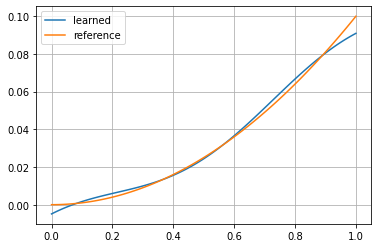

In [15]:
scale = 0.2
test_fn_input = (scale * point_grid.unsqueeze(-1))
if isinstance(model, tp.models.DeepONet):
    model_out = model(None, test_fn_input).as_tensor
else:
    model_out = model(test_fn_input).as_tensor

import matplotlib.pyplot as plt

plt.plot(point_grid.unsqueeze(-1)[0], model_out.detach()[0])
plt.plot(point_grid.unsqueeze(-1)[0], scale/2.0*point_grid.unsqueeze(-1)[0]**2)
plt.legend(["learned", "reference"])
plt.grid()